## Experiment

This is only the experiment about using distribute strategy.    
Using MirroredStrategy eagerly has significant overhead currently.   
SO DON'T RUN ON MULTI-GPU NOW.   

When using @tf.function to execute in a graph mode, this code can't use Tensor.numpy() function.    
That means functions in `detection/utils/misc.py` don't work.   

And for now, I can't find an alternative.

In [1]:
import os
import tensorflow as tf
import numpy as np
import visualize

# tensorflow config - using one gpu and extending the GPU 
# memory region needed by the TensorFlow process
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.Session(config=config)

#### load dataset

In [2]:
from detection.datasets import coco, data_generator

In [3]:
img_mean = (123.675, 116.28, 103.53)
# img_std = (58.395, 57.12, 57.375)
img_std = (1., 1., 1.)

In [4]:
train_dataset = coco.CocoDataSet('./COCO2017/', 'val',
                                 flip_ratio=0.5,
                                 pad_mode='fixed',
                                 mean=img_mean,
                                 std=img_std,
                                 scale=(640, 832),
                                 debug=True)

train_generator = data_generator.DataGenerator(train_dataset)


loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


#### load model

In [5]:
from detection.models.detectors import faster_rcnn

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    
    model = faster_rcnn.FasterRCNN(
        num_classes=len(train_dataset.get_categories()))
    
    img, img_meta, _, _ = train_dataset[0]
    batch_imgs = tf.Variable(np.expand_dims(img, 0))
    batch_metas = tf.Variable(np.expand_dims(img_meta, 0))
    _ = model((batch_imgs, batch_metas), training=False)
    
    model.load_weights('weights/faster_rcnn.h5', by_name=True)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

#### use tf.data

In [6]:
global_batch_size = 2

with strategy.scope():
    train_tf_dataset = tf.data.Dataset.from_generator(
        train_generator, (tf.float32, tf.float32, tf.float32, tf.int32))
    train_tf_dataset = train_tf_dataset.padded_batch(
        global_batch_size, padded_shapes=([None, None, None], [None], [None, None], [None]))
    train_tf_dataset = train_tf_dataset.prefetch(100).shuffle(100)
    
    dist_dataset = strategy.experimental_distribute_dataset(train_tf_dataset)

    

#### train model

In [7]:
with strategy.scope():

    def train_step(inputs):
        batch_imgs, batch_metas, batch_bboxes, batch_labels = inputs
        with tf.GradientTape() as tape:
            rpn_class_loss, rpn_bbox_loss, rcnn_class_loss, rcnn_bbox_loss = \
                model((batch_imgs, batch_metas, batch_bboxes, batch_labels), training=True)

            loss_value = rpn_class_loss + rpn_bbox_loss + rcnn_class_loss + rcnn_bbox_loss
            loss = tf.reduce_sum(loss_value) * (1.0 / global_batch_size)


        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        return loss_value
    

In [8]:
with strategy.scope():
 
    def distributed_train_step(inputs):
        per_replica_losses = strategy.experimental_run_v2(train_step,
                                                          args=(inputs,))
        return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                               axis=None)
    
    
    optimizer = tf.keras.optimizers.SGD(1e-3, momentum=0.9, nesterov=True)

    epochs = 12

    for epoch in range(epochs):

        loss_history = []
        for (batch, inputs) in enumerate(train_tf_dataset):
            
            batch_loss = distributed_train_step(inputs)

            loss_history.append(batch_loss.numpy())

            print('epoch:', epoch, ' batch:', batch, ' loss:', np.mean(loss_history))

Instructions for updating:
Use tf.identity instead.
INFO:tensorflow:batch_all_reduce: 450 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
epoch: 0  batch: 0  loss: 4.2769685
INFO:tensorflow:batch_all_reduce: 450 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
epoch: 0  batch: 1  loss: 5.7886753
INFO:tensorflow:batch_all_reduce: 450 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
epoch: 0  batch: 2  loss: 5.410507
INFO:tensorflow:batch_all_reduce: 450 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
epoch: 0  batch: 3  loss: 5.4916773
INFO:tensorflow:batch_all_reduce: 450 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
epoch: 0  batch: 4  loss: 5.086756
INFO:

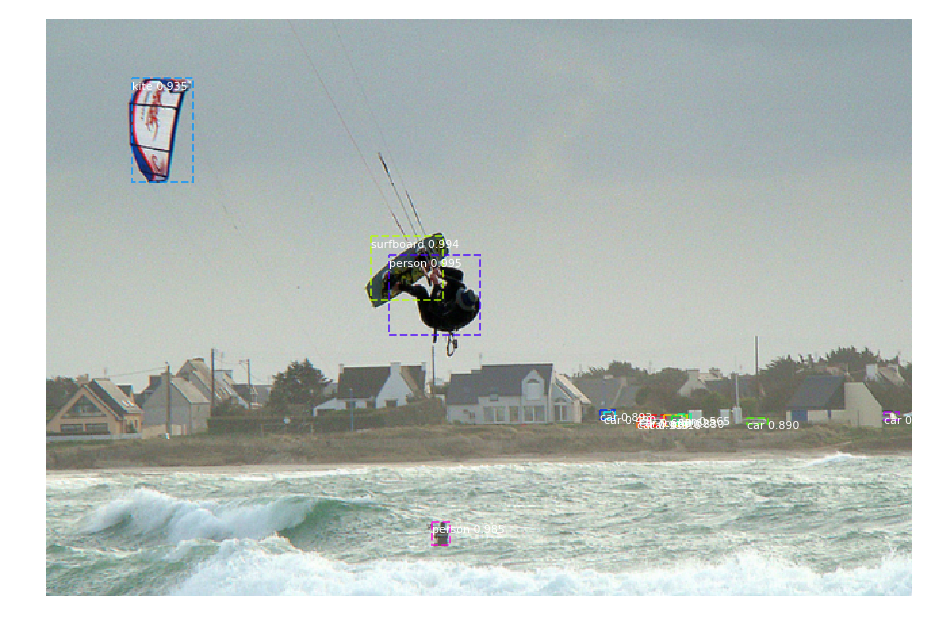

In [9]:
with strategy.scope():
    from detection.datasets.utils import get_original_image
    ori_img = get_original_image(img, img_meta, img_mean)
    proposals = model.simple_test_rpn(img, img_meta)
    res = model.simple_test_bboxes(img, img_meta, proposals)
    visualize.display_instances(ori_img, res['rois'], res['class_ids'], 
                            train_dataset.get_categories(), scores=res['scores'])